This notebook does 2 things:

1. Applies different resenet architectures and selects the
   model and architecture based on the validation loss.

1. Calculates AUC ROC score fo the best model.

In [24]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from fastai2.metrics import RocAuc
from fastai2.vision.all import *

from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(42)

In [25]:
df = pd.read_csv('data/train.csv')

In [26]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [27]:
y_train, y_test = train_test_split(df.target, random_state=42, 
                                   test_size=0.33)

In [28]:
train_pos_indexes = y_train[y_train==1].index

In [30]:
train_neg_indexes = np.random.choice(y_train[y_train==0].index,3840)

In [44]:
df['purpose'] = np.nan

In [45]:
df.loc[y_test.index.tolist() ,'purpose'] = 'val'
df.loc[train_pos_indexes, 'purpose' ] = 'train'
df.loc[train_neg_indexes, 'purpose' ] = 'train'

In [47]:
def custom_splitter(df):
    train = df.index[df.purpose=='train'].tolist()
    val   = df.index[df.purpose=='val'].tolist()

    return train, val

In [48]:
dblock = DataBlock((ImageBlock, CategoryBlock),
                   splitter = custom_splitter,
                   get_x = lambda r: f"data/jpeg/train-224/{r['image_name']}.jpg",
                   get_y = lambda r : str(r["target"]),
                   item_tfms = None)


dls = dblock.dataloaders(df,bs=32, num_workers = 0)


In [49]:
x,y = dls.one_batch()

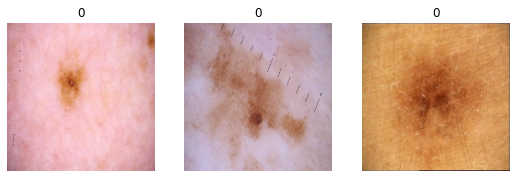

In [54]:
dls.show_batch(nrows=1, ncols=3)

In [55]:
learn = cnn_learner(dls, resnet18,metrics = [accuracy, RocAuc()],
                   loss=BCEWithLogitsLossFlat())

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=2.2908675418875646e-06)

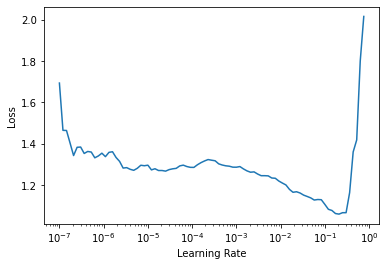

In [15]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, lr=3e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.804008,0.345008,0.858306,0.648144,00:49
